# Titanic Survival Prediction 

### Data dictionary

| Variable   |      Definition      |  Key |
|----------|:-------------:|------:|
| survival |  Survival | 0 = No, 1 = Yes |
| pclass |Ticket class   |   1 = 1st, 2 = 2nd, 3 = 3rd |
| sex | Sex |   |
| age | Age in years |   |
| sibsp | # of siblings |     |
| parch | # of parents |  |
| ticket | Ticket number |     |
| fare | Passenger fare | |
| cabin | Cabin number | |
| embarked | Port of Embarkmenmt |  C = Cherbourg, Q = Queenstown, S = Southampton |

- **survival**: Column we are goin to try to predict, values are either 0 or 1 (classification problem)
- **pclass**: A proxy for socio-economic status (SES)
  - 1st = Upper
  - 2nd = Middle
  - 3rd = Lower
- **age**: Age is fractional if less than 1. If the age is estimated, it is in the form of xx.5
- **sibsp**: Defines family relations
  - Sibling = brother, sister, stepbrother, stepsister
  - Spouse = husband, wife (mistresses and fiancés were ignored)
- **parch**: Defines family relations
  - Parent = mother, father
  - Child = daughter, son, stepdaughter, stepson
  - Some children travelled only with a nanny, therefore parch=0 for them.

In [1]:
import pandas as pd 
import optuna
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from scipy.stats import skew
import warnings
warnings.filterwarnings("ignore")

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import QuantileTransformer , MinMaxScaler, LabelEncoder

from sklearn.model_selection import train_test_split, cross_val_score

import lightgbm as lgb
from catboost import CatBoostClassifier
from catboost.utils import eval_metric
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import *

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# Palette
palette = ['#03045E','#0077B6','#00B4D8','#90E0Ef', '#CAF0F8']
color_palette = sns.color_palette(palette)

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
test_id = test_df['PassengerId']

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
rows_train, columns_train = train_df.shape
rows_test, columns_test = test_df.shape

print('Training set consists of {s} samples'.format(s=rows_train))
print('Testing set consists of {s} samples'.format(s=rows_test))

Training set consists of 891 samples
Testing set consists of 418 samples


In [5]:
print('Summary of training set: ')
train_df.info()

Summary of training set: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
def null_values(df):
    rows, columns = df.shape
    
    null_df = df.isnull().sum()
    null_df = pd.DataFrame(null_df, columns = ['Total null'])
    null_df['% null'] = round(null_df['Total null']/rows * 100,2)
    
    return null_df

print('Training set null values: ')
null_values(train_df)

Training set null values: 


,Total null,% null
PassengerId,0,0.00
Survived,0,0.00
Pclass,0,0.00
Name,0,0.00
Sex,0,0.00
Age,177,19.87
SibSp,0,0.00
Parch,0,0.00
Ticket,0,0.00
Fare,0,0.00


In [7]:
print('Test set null values: ')
null_values(test_df)

Test set null values: 


,Total null,% null
PassengerId,0,0.00
Pclass,0,0.00
Name,0,0.00
Sex,0,0.00
Age,86,20.57
SibSp,0,0.00
Parch,0,0.00
Ticket,0,0.00
Fare,1,0.24
Cabin,327,78.23


## **Handling null values**
### Training set: 
- **Age** column we are going to use an imputer to estimate the missing values
- In the **Embarked** column we are only missing 2 values, this is such a low number we can use an Imputer with a simple strategy such as 'Most Frequent' to fill the missing values.
- In the **Cabin** column we cannot do the same because we are missing too many values (more than 75%) so we are better off removing the column so we don't introduce bias into the dataset.

### Test set:
We are goin to perform the same operations in the test:
- Use an iterative imputer to estimate the missing values in the **Age** column.
- In this case the **Embarked** column has 0 missing values, but the **Fare** column has a single null value, which we will also fill using the iterative imputer.
- Remove completely the **Cabin** column.

In [8]:
I_M = IterativeImputer()
train_df['Age'] = I_M.fit_transform(train_df[['Age']])

S_I = SimpleImputer(strategy='most_frequent')
train_df[['Embarked']] = S_I.fit_transform(train_df[['Embarked']]) 

train_df.drop('Cabin',axis=1, inplace=True)

print('Training set null values:')
null_values(train_df)

Training set null values:


,Total null,% null
PassengerId,0,0.0
Survived,0,0.0
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
Age,0,0.0
SibSp,0,0.0
Parch,0,0.0
Ticket,0,0.0
Fare,0,0.0


In [9]:
I_M_test = IterativeImputer()
test_df['Age'] = I_M_test.fit_transform(test_df[['Age']])
test_df['Fare'] = I_M_test.fit_transform(test_df[['Fare']])

test_df.drop('Cabin',axis=1, inplace=True)

print('Test set null values:')
null_values(test_df)

Test set null values:


,Total null,% null
PassengerId,0,0.0
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
Age,0,0.0
SibSp,0,0.0
Parch,0,0.0
Ticket,0,0.0
Fare,0,0.0
Embarked,0,0.0


## **Exploratory Data Analysis (EDA)**

I will perform some feature engineering to add some new features that might help the model predict the survival of a passenger. These new features have been taken from the following kaggle notebook: 

https://www.kaggle.com/code/psegdava/embark-on-titanic-a-beginner-s-journey-through-ml/edit

### New features:
- **Family size**: taking the number of siblings and number of parents
- **Title**: extracting the title from the full name of the passenger
- **Is alone**: if the family size is 1
- **Age group**: perform banding in the age column to reduce the possible values of age to four
- **Fare per Person**: Fare paid divided by the Family size
- **Age*Class**
- **Sex_Class**

It is important to perform the feature engineering on both the training set and the test set as they need to have the same final features.

In [10]:
def feature_engineering(dataset):
    # Family Size
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

    # Title
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

    # IsAlone
    dataset['IsAlone'] = (dataset['FamilySize'] == 1).astype(int)

    # Age Group
    dataset['AgeGroup'] = pd.cut(dataset['Age'], bins=[0-10, 18, 30, 50, 100], labels=['Child', 'Young Adult', 'Adult', 'Elderly'])

    # Fare per Person
    dataset['FarePerPerson'] = dataset['Fare'] / dataset['FamilySize']

    # Ticket Frequency
    ticket_counts = dataset['Ticket'].value_counts()
    dataset['TicketFrequency'] = dataset['Ticket'].apply(lambda x: ticket_counts[x])

    # Age * Class
    dataset['Age*Class'] = dataset['Age'] * dataset['Pclass']

    # Sex and Class
    dataset['Sex_Class'] = dataset['Sex'] + '_' + dataset['Pclass'].astype(str)
    
    # Return Data 
    return dataset

# Train And test 
train_df = feature_engineering(train_df)
test_df = feature_engineering(test_df)

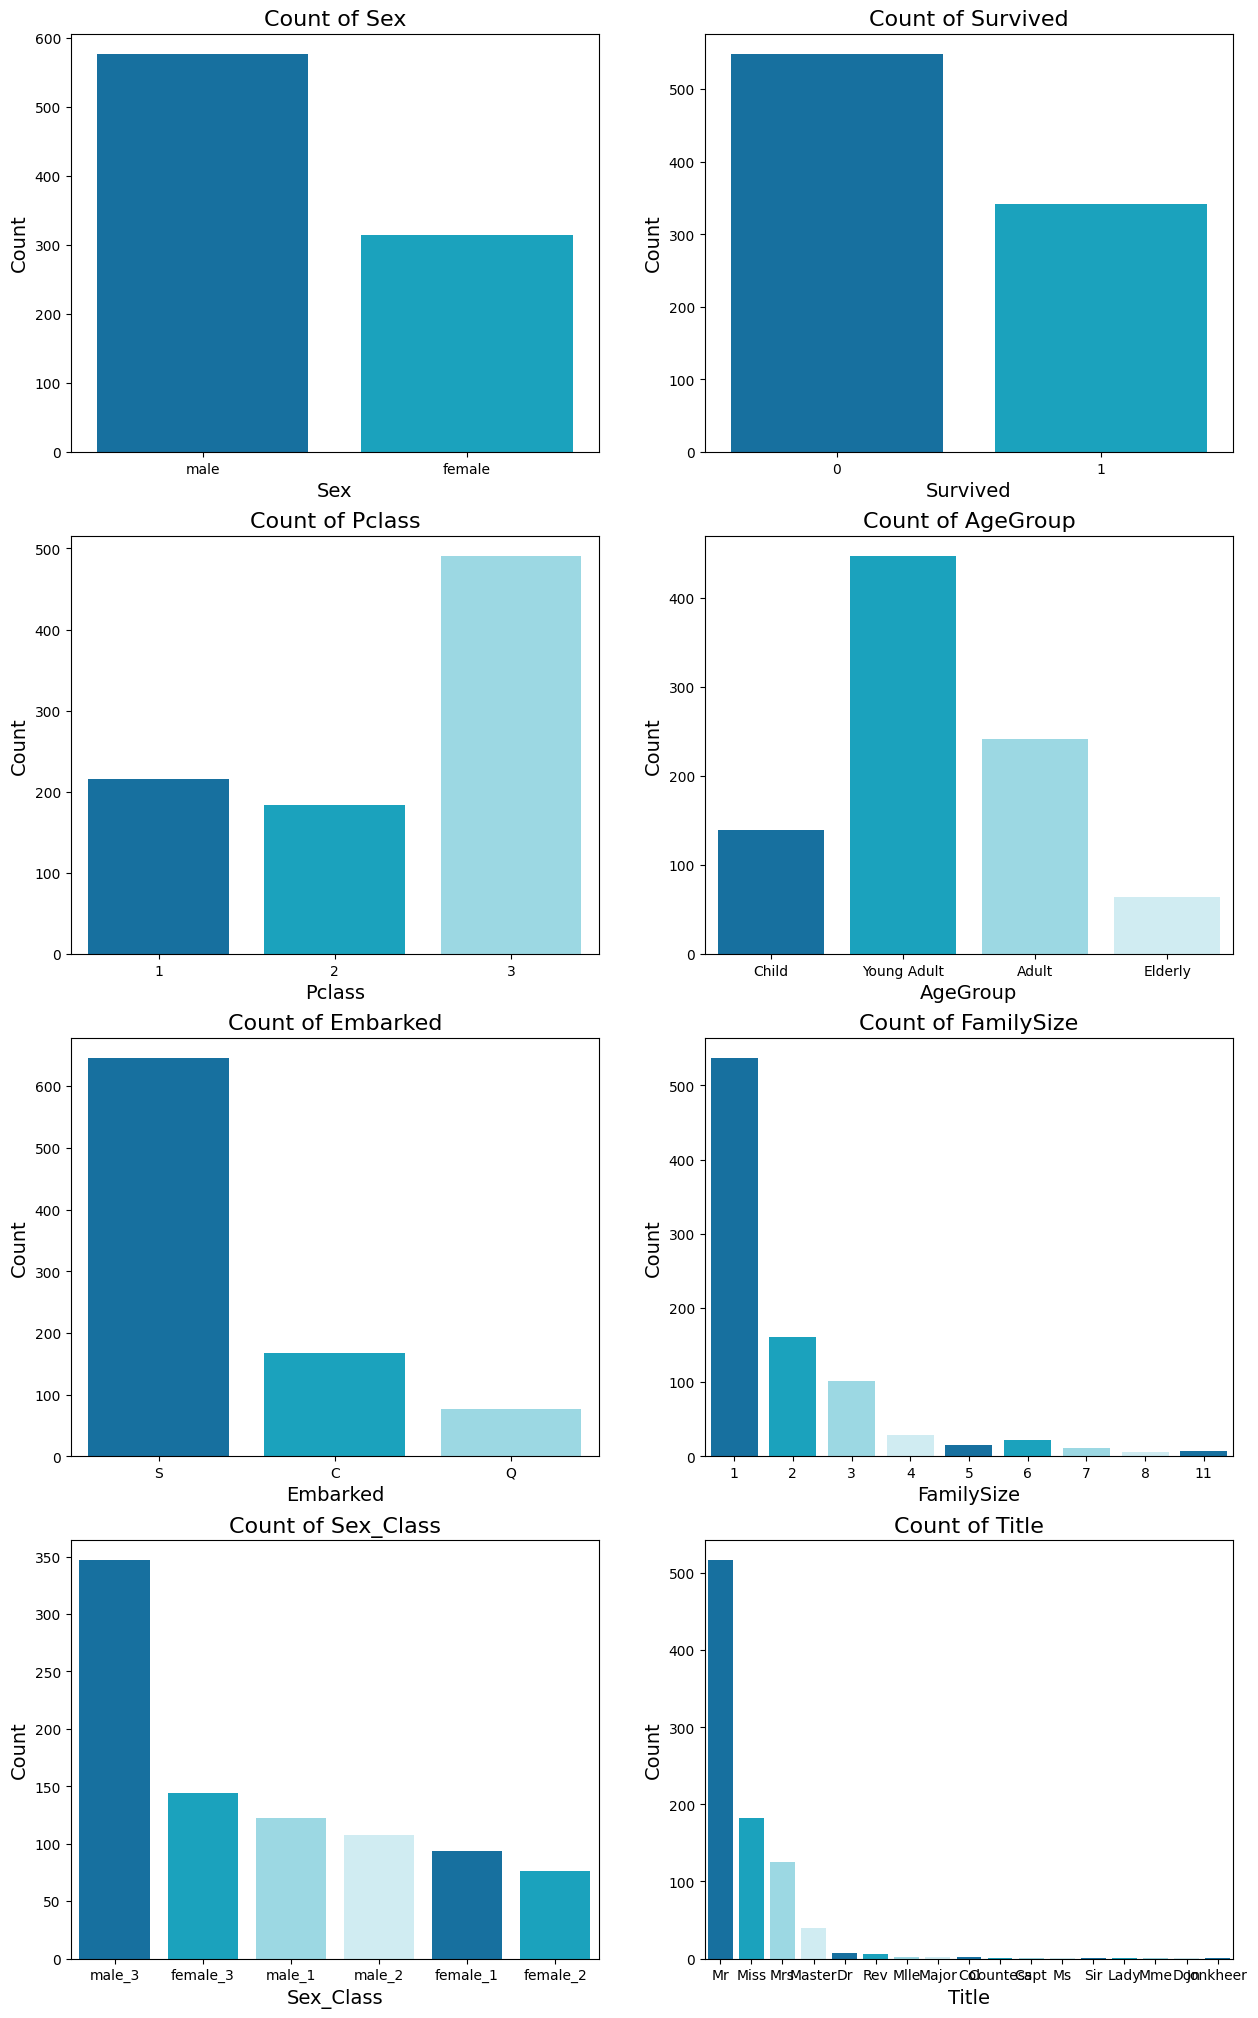

In [11]:
columns = ['Sex', 'Survived', 'Pclass', 'AgeGroup', 'Embarked', 'FamilySize', 'Sex_Class', 'Title']
fig, axs = plt.subplots(4, 2, figsize=(15, 25), gridspec_kw={'width_ratios': [1, 1]})
custom_palette = color_palette[1:5]
    
for i, col in enumerate(columns):
    counts = train_df[col].value_counts()
    sns.barplot(x=counts.index, y=counts.values, ax=axs[i // 2, i % 2], palette=custom_palette) 
    axs[i // 2, i % 2].set_title(f'Count of {col}', fontsize=16)
    axs[i // 2, i % 2].set_xlabel(col, fontsize=14)
    axs[i // 2, i % 2].set_ylabel('Count', fontsize=14)

### Some observations:
- There is a higher ratio of men to women, approximately 50% more men than women.
- Significantly more people died than survived the disaster.
- More passengers travelled in lower class, compared to first or second class
- Young adult is clearly the age group with highest representation, and Elderly is the group with the lowest representation.
- Most people travelled alone, representing more than 50% of the total passengers. And as family size increases the amount of observations decreases drastically.
- Most passengers in the ship belonged to the male_3 group (males with third class tickets).

In [12]:
train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [13]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [14]:
train_df[['AgeGroup', 'Survived']].groupby(['AgeGroup'], as_index=False).mean()

,AgeGroup,Survived
0,Child,0.503597
1,Young Adult,0.331096
2,Adult,0.423237
3,Elderly,0.343750


We can make some early observations from the analysis we have done so far:
- **Sex survival bias:** Most men did not survive while most women did survive, we also have to take into account that there were more men than women on the ship.
- **Lower class high mortality rate:** From the passengers that did not survive most of them were in the lower class, and if we look at the lower class, it is the class with highest male to female ratio.
- **Age factor in survival chances:** Lastly we can say that Young Adults (18-30 years old) also had a higher mortality rate than other age group. Elderly people also have a low survival rate.


## **Numerical Feature Distribution**

In [15]:
# Numerical Distribution Plot
def plot_numerical_distribution_with_hue(data, num_cols, hue_col='Survived', figsize=(12, 8), dpi=100):
    # Create subplots
    fig, ax = plt.subplots(2, 2, figsize=figsize, dpi=dpi)
    ax = ax.flatten()  # Flatten the array
    
    # Loop through each column and plot the distribution with hue
    for i, column in enumerate(num_cols):  # Plotting only the first four columns
        sns.histplot(data=data, x=column, hue=hue_col, ax=ax[i], kde=True, palette=palette[0:2])
        ax[i].set_title(f'{column} Distribution', size=14)
        ax[i].set_xlabel(None)
        ax[i].set_ylabel(None)
        
        # Calculate skewness
        skewness = skew(data[column].dropna())
        skew_label = f'Skewness: {skewness:.2f}'
        
        # Add skewness annotation
        ax[i].annotate(skew_label, xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12, color='red')
    
    # Set Tight Layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

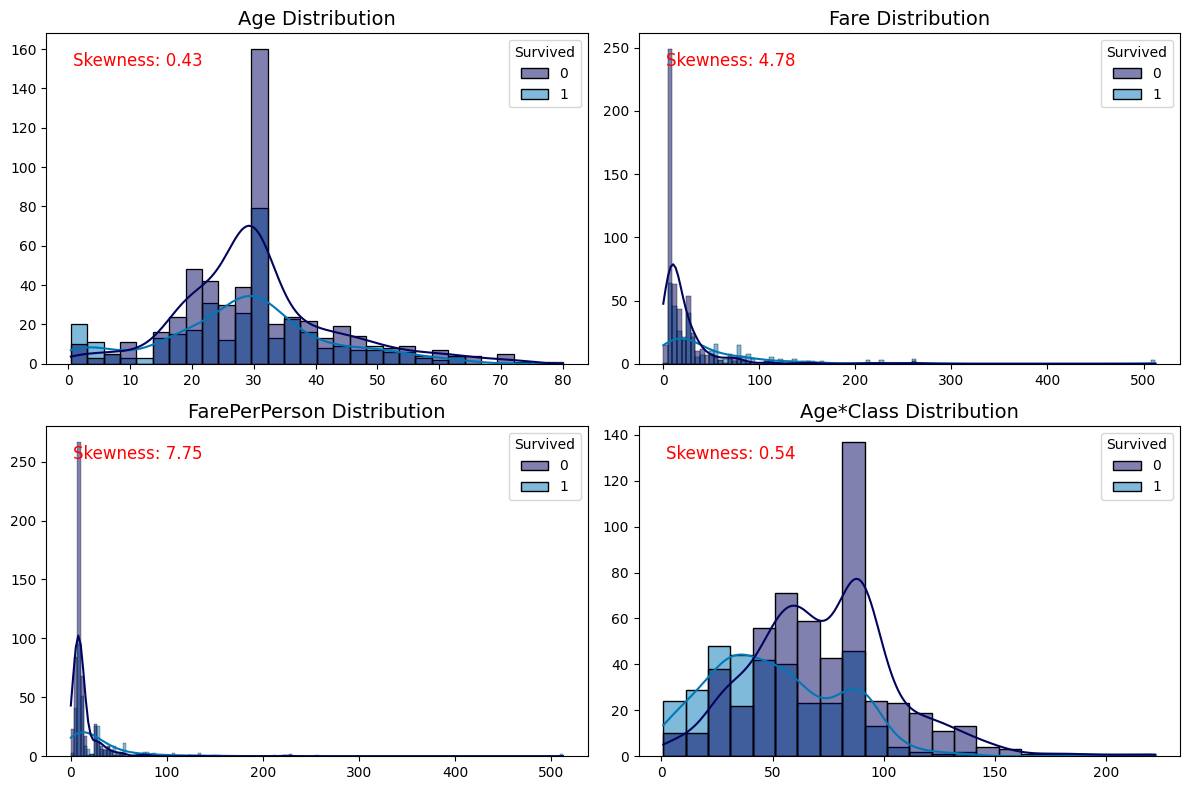

In [16]:
# Cols to Plot
numerical_columns = [col for col in train_df.columns if train_df[col].dtype == 'float']
# Numerical Distribution of Age Vs Fare
plot_numerical_distribution_with_hue(train_df,numerical_columns,'Survived')

We can observe two things from the numerical features:
- **Age** has a decent normal distribution with low skewness but it is not exactly normal, and smae thing for **Age*Class**
- **Fare** and by continuation **FarePerPerson** are very highly right skewed

We need to normalize these features to make them more useful, we will use a QuantileTransformer to map them to a normal distribution.

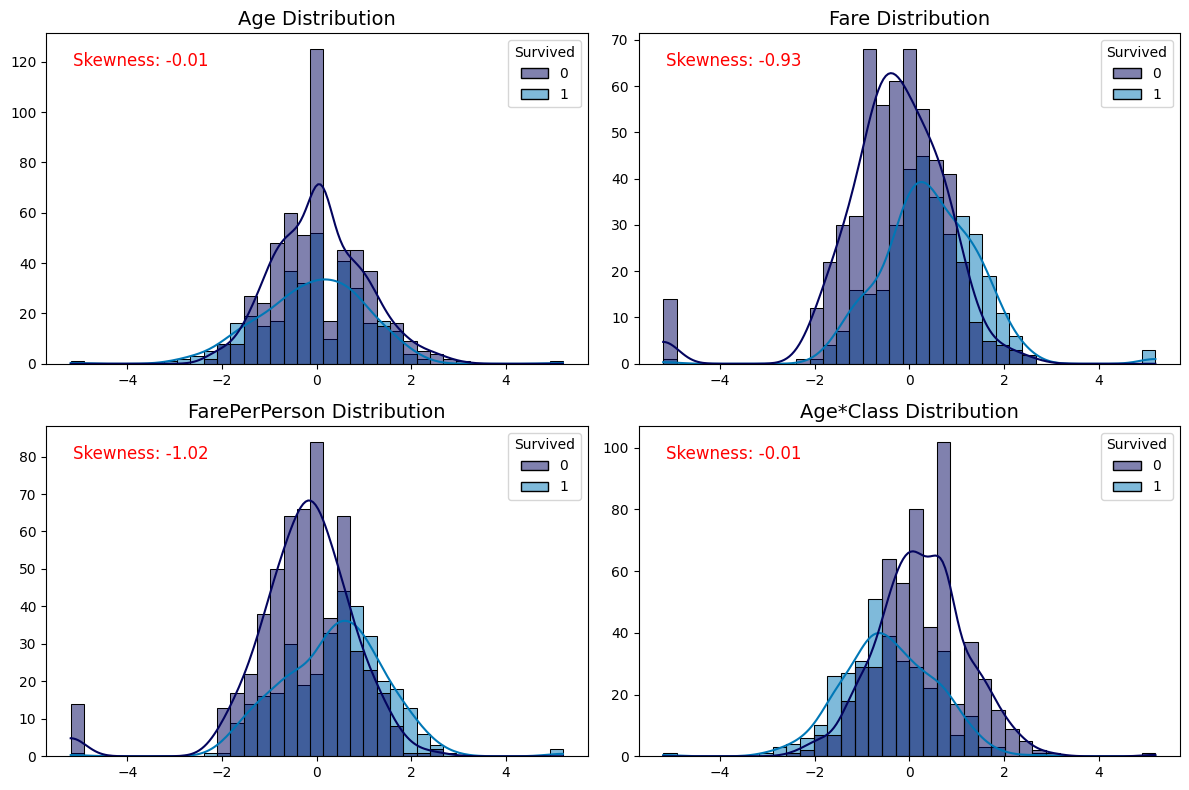

In [17]:
quant_transformer = QuantileTransformer(output_distribution='normal')

for col in numerical_columns:
    train_df[col] = quant_transformer.fit_transform(train_df[[col]])
    
for col in numerical_columns:
    test_df[col] = quant_transformer.fit_transform(test_df[[col]])
    
plot_numerical_distribution_with_hue(train_df,numerical_columns,'Survived')

We now have our numerical columns following a normal distribution which is much better for our future models classifying capabilities

## **Encoding Categorical Features**

We will have a look at the number of unique values in each categorical feature to determine the type of encoding we will use for each one

In [18]:
print('Number of unique values in each feature: ')
categorical_columns = [col for col in train_df.columns if train_df[col].dtype in ['object', 'category']]
categorical_df = train_df[categorical_columns]
categorical_df.nunique()

Number of unique values in each feature: 


Name         891
Sex            2
Ticket       681
Embarked       3
Title         17
AgeGroup       4
Sex_Class      6
dtype: int64

From this table we can conclude: 
- **Name** and **Ticket** columns have a large number of unique values, which makes label encoding not a very ueful technique. Instead we are going to remove these columns as they are not important features to predict the survival chance of a passenger. (We will also remove passengerID as it is a unique value for each passenger which doesn't hold much predictablity value)
- But **Sex**, **Embarked**, **Title**, **AgeGroup** and **Sex_Class** all have manageable number of unique values so we will use Label encoding on them.

In [19]:
le_columns = ['Sex', 'Embarked', 'Title', 'AgeGroup', 'Sex_Class']
le = LabelEncoder()

for col in le_columns:
    train_df[col] = le.fit_transform(train_df[[col]])
  
for col in le_columns:
    test_df[col] = le.fit_transform(test_df[[col]])

In [20]:
train_df.drop(['Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)
test_df.drop(['Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Survived         891 non-null    int64  
 1   Pclass           891 non-null    int64  
 2   Sex              891 non-null    int64  
 3   Age              891 non-null    float64
 4   SibSp            891 non-null    int64  
 5   Parch            891 non-null    int64  
 6   Fare             891 non-null    float64
 7   Embarked         891 non-null    int64  
 8   FamilySize       891 non-null    int64  
 9   Title            891 non-null    int64  
 10  IsAlone          891 non-null    int64  
 11  AgeGroup         891 non-null    int64  
 12  FarePerPerson    891 non-null    float64
 13  TicketFrequency  891 non-null    int64  
 14  Age*Class        891 non-null    float64
 15  Sex_Class        891 non-null    int64  
dtypes: float64(4), int64(12)
memory usage: 111.5 KB


## **Scaling**

In [22]:
# Scaling Train and test 
# Scaler
scaler = MinMaxScaler()

# Loop
for col in train_df.columns:
    train_df[col] = scaler.fit_transform(train_df[[col]])
for col in test_df.columns:
    test_df[col] = scaler.fit_transform(test_df[[col]])

## **Correlation Matrix**

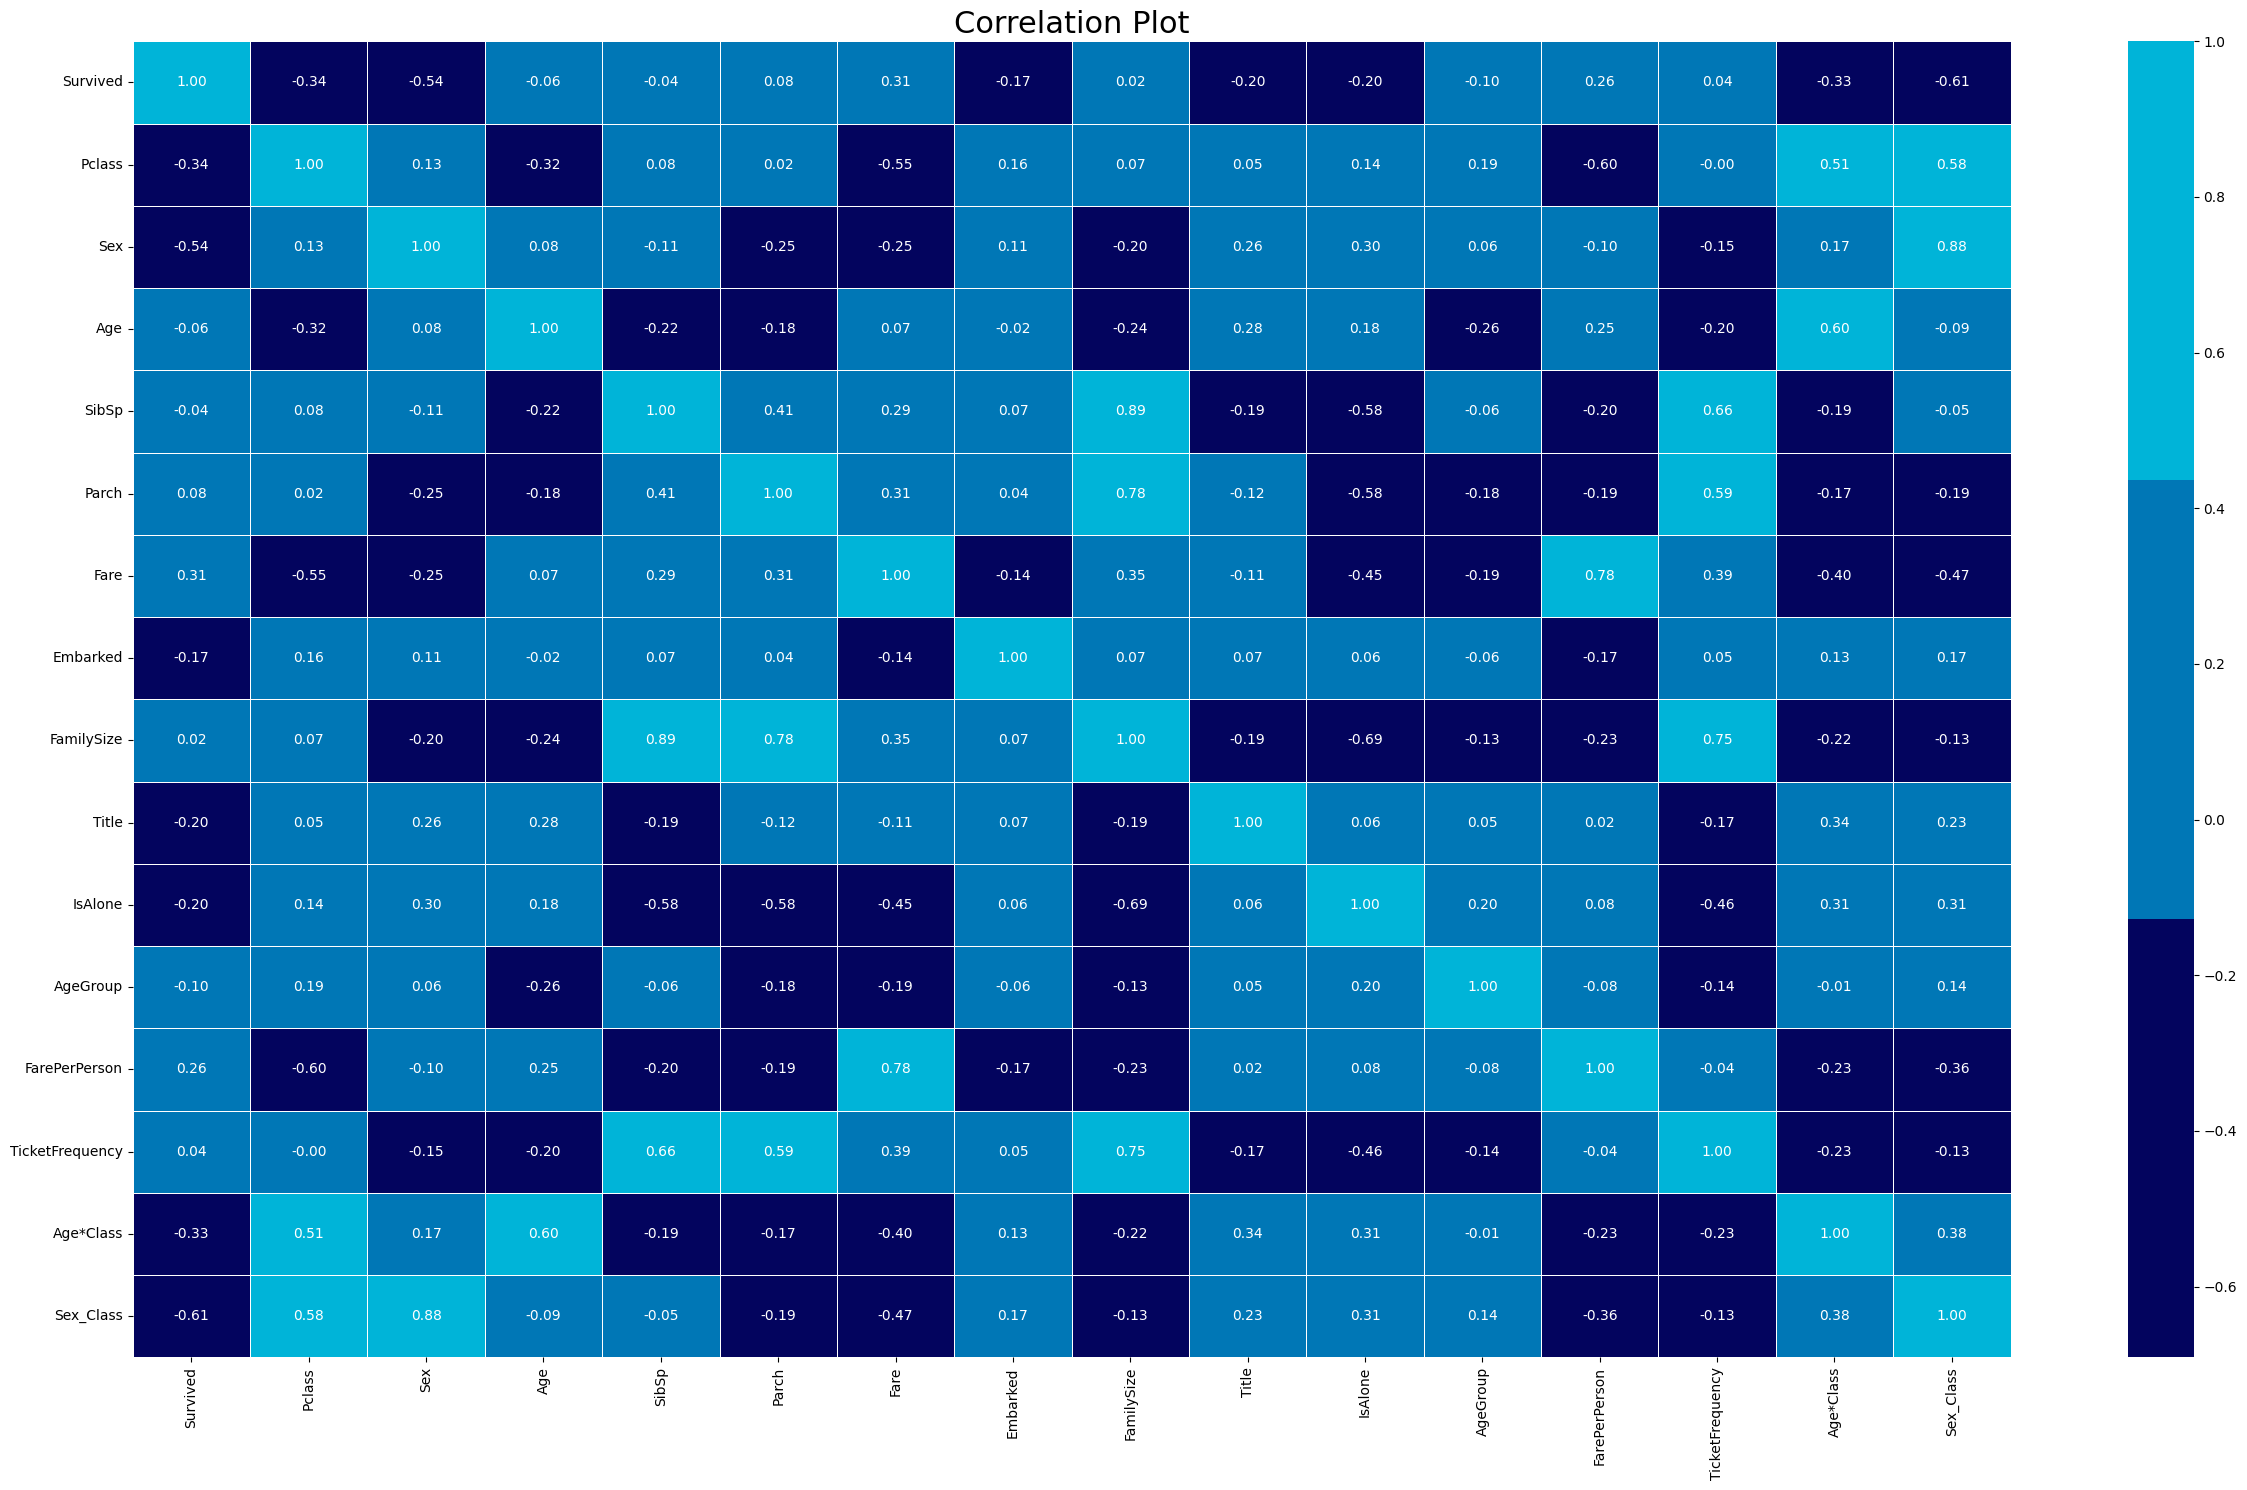

In [23]:
corr_matrix = train_df.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(25, 15))
sns.heatmap(corr_matrix, annot=True, cmap=palette[0:3], fmt=".2f", linewidths=0.5)
plt.title('Correlation Plot', fontsize=22)  
plt.tight_layout()  
plt.show()

## **Train Test Split**

In [24]:
y = train_df['Survived']
X = train_df.drop('Survived', axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

print('Training size: ',X_train.shape[0])
print('Validation size: ',X_valid.shape[0])

Training size:  712
Validation size:  179


# **Model Building**

We will try a few classifying models on the data, we will try them without optimizing hyperparameters to obtain a baseline score on all the models and compare them to see which one performs better and later concentrate on optimizing the best one.

In [25]:
models = {'Logistic Regresssion': LogisticRegression(),
          'SVC': SVC(),
          'Decision Tree Classifier': DecisionTreeClassifier(random_state=42),
          'Random Forest Classifier': RandomForestClassifier(random_state=42),
          'KNeighbors Classifier': KNeighborsClassifier(),
          'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=42),
          'XGB Classifier': XGBClassifier(random_state=230),
          'CatBoost Classifier': CatBoostClassifier(silent=True),
          'AdaBoostClassifier': AdaBoostClassifier(random_state=42),
          'GaussianNB': GaussianNB(),
          'LGBMClassifier': lgb.LGBMClassifier(verbose=-1)
}

In [26]:
model_scores = []

for name, model in models.items():
    cv_scores = cross_val_score(model, X, y, cv=3, scoring='accuracy')
    accuracy = cv_scores.mean()
    model_scores.append((name,accuracy))

columns = ['Model', 'Accuracy']
model_scores_df = pd.DataFrame(model_scores, columns=columns)

model_scores_df = model_scores_df.sort_values(by='Accuracy', ascending=False)

model_scores_df

,Model,Accuracy
7,CatBoost Classifier,0.833895
5,Gradient Boosting Classifier,0.822671
8,AdaBoostClassifier,0.814815
3,Random Forest Classifier,0.812570
6,XGB Classifier,0.812570
1,SVC,0.810325
10,LGBMClassifier,0.810325
4,KNeighbors Classifier,0.792368
0,Logistic Regresssion,0.789001
9,GaussianNB,0.787879


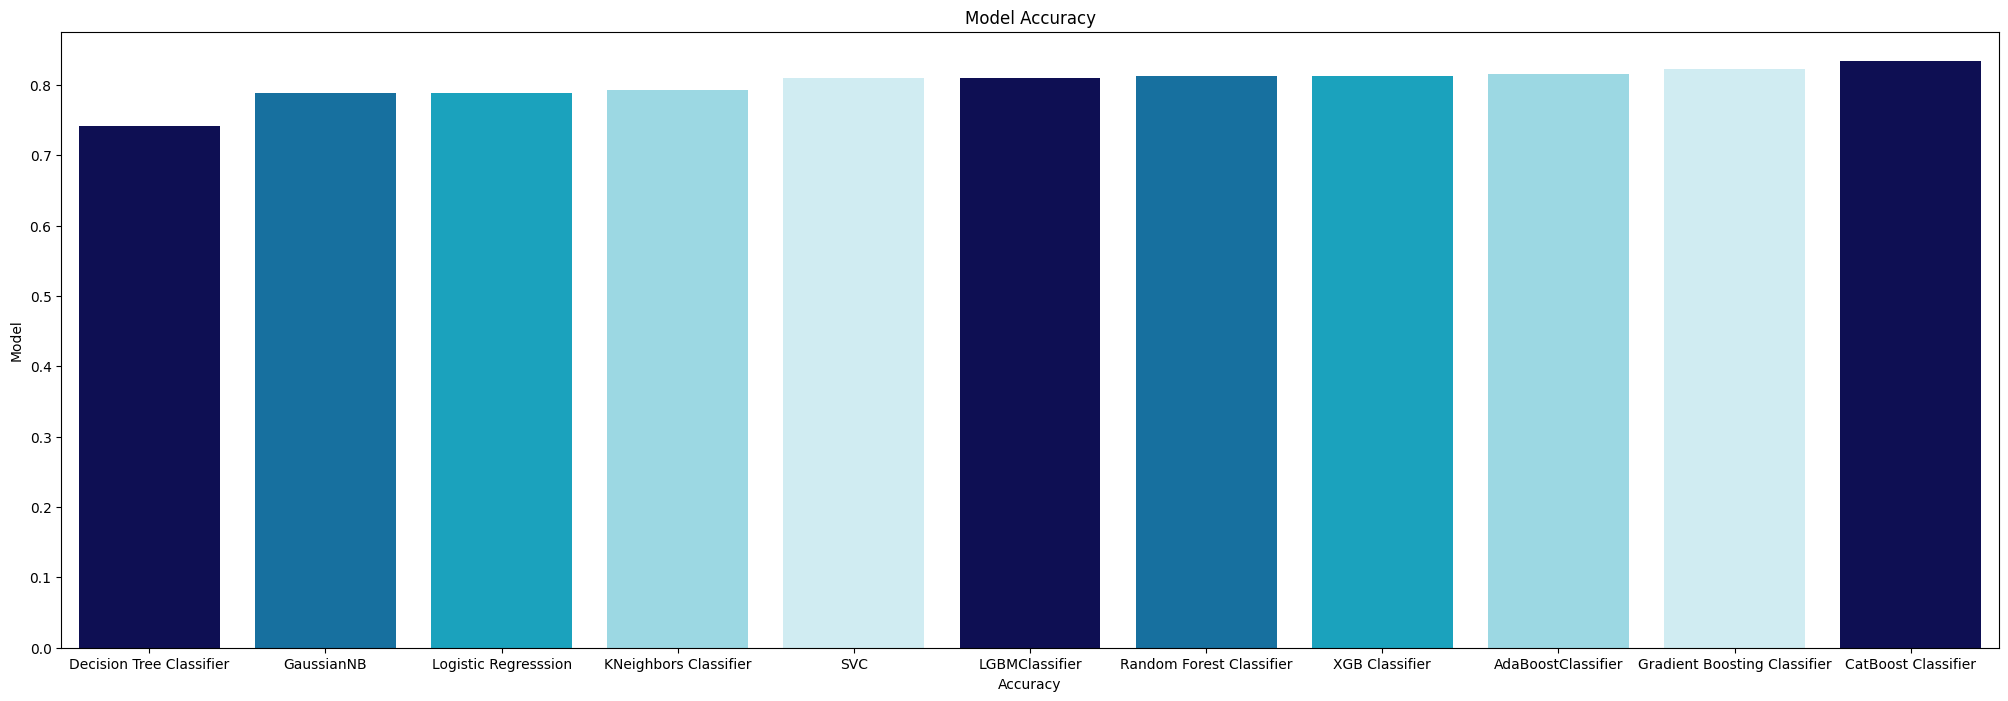

In [27]:
plt.figure(figsize=(25,8))
sns.barplot(x='Model', y='Accuracy', data=model_scores_df.sort_values(by='Accuracy'), palette=palette[0:5])
plt.title('Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()

We can clearly see the best performing model is the **CatBoost Classifier** while the worst performing one is the simple **Decision Tree Classifier**

## **CatBoost Parameter Tuning**
I will use Optuna to search for the best performing parameters for the Catboost model

In [28]:
def objective(trial):
    
    params = {'iterations': trial.suggest_int('iterations',100,1000),
             'learning_rate': trial.suggest_float('learning_rate',0.001,0.2),
             'depth': trial.suggest_int('depth',4,16),
             'subsample': trial.suggest_float("subsample", 0.3, 1.0),
             'colsample_bylevel': trial.suggest_float("colsample_bylevel", 0.3, 1.0),
             'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 1, 100)}
    
    model = CatBoostClassifier(**params, silent=True)
    model.fit(X_train, y_train)
    accuracy = model.score(X_valid, y_valid)
    
    return accuracy

In [29]:
#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=50)

In [30]:
#print(study.best_params)
#print(study.best_value)

In [31]:
best_params = {'iterations': 317, 
               'learning_rate': 0.078318651147293, 
               'depth': 15, 
               'subsample': 0.7036111731263703, 
               'colsample_bylevel': 0.7998622229848094, 
               'min_data_in_leaf': 16}

Now that we have the best parameters we will train a model with these parameters and evaluate it using cross validation

In [32]:
best_model = CatBoostClassifier(**best_params, silent=True)
cv_scores = cross_val_score(model, X, y, cv=20, scoring='accuracy')
avg_accuracy = cv_scores.mean()
avg_accuracy

0.8159343434343432

In [33]:
best_model.fit(X,y)
y_test_predict = best_model.predict(test_df)

In [34]:
sub = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
sub['Survived'] = y_test_predict.astype(int)
sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [35]:
sub.to_csv('submission.csv', index=False)